In [12]:
import os
import numpy as np
import mne
from data_reader_2023 import *
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy import fftpack
# import h5py 
import random
import shutil
from scipy.signal import iirnotch, lfilter
from scipy.fft import rfft, rfftfreq
import pandas as pd

## Define Constants and Key Variables

In [2]:
########### Constants
# Define bandpass filter constants
lowcut = 0.5
highcut = 120
fs = 1024
resampleFS = 250

# Create the notch filter
notch_1_b, notch_1_a = iirnotch(1, Q=30, fs=resampleFS)
notch_60_b, notch_60_a = iirnotch(60, Q=30, fs=resampleFS)
# notch_100_b, notch_100_a = iirnotch(100, Q=30, fs=250)

# Define segment interval length in sec
segment_interval = 4
print('Segment Interval: ', segment_interval)

# Seizure types

binary_classifier_flag = True

# seizure_types = ['fnsz', 'gnsz', 'cpsz', 'absz', 'tnsz', 'tcsz', 'bckg']
if binary_classifier_flag:
    seizure_types = ['bckg', 'seizure']
    seizure_session_downsampling_ratio = [1, 1]
    seizure_overlapping_ratio = [0, 0.75]
else:
    seizure_types = ['fnsz', 'gnsz', 'cpsz', 'bckg']
    seizure_session_downsampling_ratio = [1, 1, 1, 1]
    seizure_overlapping_ratio = [0.75, 0.75, 0.75, 0]

########## Data path

train_val_root = os.path.join('/datadrive', 'TUSZ_2023', 'edf', 'train')
test_root = os.path.join('/datadrive', 'TUSZ_2023', 'edf', 'dev')
# test_root = os.path.join('/datadrive', 'TUSZ_2023', 'edf', 'eval')


if binary_classifier_flag:
    save_root = os.path.join('/datadrive', 'TUSZ_2023', 'TUSZ_processed_binary_individual_segments')
else:
    save_root = os.path.join('/datadrive', 'TUSZ_2023', 'TUSZ_processed_multiclass_individual_segments')

print(save_root)

if not os.path.exists(save_root):
    os.mkdir(save_root)



# data_mode = 'small'
# data_mode = 'large'
# data_mode = 'tiny'
data_mode = 'full'

Segment Interval:  4
/datadrive/TUSZ_2023/TUSZ_processed_binary_individual_segments


## To delete previous data repo when running a new experiment

In [3]:
## To delete previous data repo when running a new experiment
## This is to avoid concatenating duplicate data to the existing .npy files
if not os.path.exists(os.path.join(save_root, 'segment_interval_'+str(segment_interval)+'_sec')):
    os.mkdir(os.path.join(save_root, 'segment_interval_'+str(segment_interval)+'_sec'))
else:
    for filename in os.listdir(os.path.join(save_root, 'segment_interval_'+str(segment_interval)+'_sec')):
        file_path = os.path.join(save_root, 'segment_interval_'+str(segment_interval)+'_sec', filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

In [4]:
train_val_paths, train_val_patients, train_val_reference_type_count = get_all_TUSZ_2023_session_paths(train_val_root)
# print(session_paths[0])
print('Total sessions: ', len(train_val_paths))
print('Train and val patients: ', len(train_val_patients))

# val_paths, val_patients = get_all_TUSZ_2023_session_paths(val_root)
# print('Total sessions: ', len(val_paths))
# print('Total patients: ', len(val_patients))

test_paths, test_patients, test_reference_type_count = get_all_TUSZ_2023_session_paths(test_root)
print('Test sessions: ', len(test_paths))
print('Test patients: ', len(test_patients))

all_paths = train_val_paths + test_paths
print('All sessions: ', len(all_paths))

training_data = [[] for i in range(len(seizure_types))]
validation_data = [[] for i in range(len(seizure_types))]
testing_data = [[] for i in range(len(seizure_types))]

random.seed(42)
random.shuffle(train_val_patients)
train_patients = train_val_patients[:int(len(train_val_patients)*0.8)]
val_patients = train_val_patients[int(len(train_val_patients)*0.8):]

Total sessions:  4664
Train and val patients:  579
Test sessions:  1832
Test patients:  53
All sessions:  6496


In [15]:
data_path = '/datadrive/TUSZ_2023/edf/train/aaaaaacz/s003_2010_01_21/01_tcp_ar/aaaaaacz_s003_t000.edf'
label_file = data_path[:-4] + '.csv'
df = pd.read_csv(label_file, skiprows=5, header=0)
df

,channel,start_time,stop_time,label,confidence
0,FP1-F7,0.0,1205.0,bckg,1.0
1,F7-T3,0.0,1205.0,bckg,1.0
2,T3-T5,0.0,1205.0,bckg,1.0
3,T5-O1,0.0,1205.0,bckg,1.0
4,FP2-F8,0.0,1205.0,bckg,1.0
5,F8-T4,0.0,1205.0,bckg,1.0
6,T4-T6,0.0,1205.0,bckg,1.0
7,T6-O2,0.0,1205.0,bckg,1.0
8,A1-T3,0.0,1205.0,bckg,1.0
9,T3-C3,0.0,1205.0,bckg,1.0


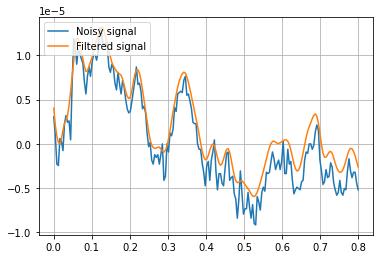

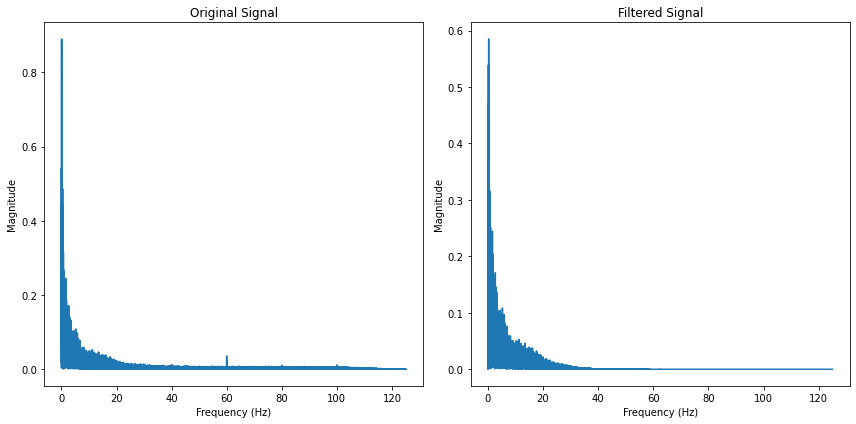

In [8]:
count_session = 0

for data_path in train_val_paths:

    patient = data_path.split('train/')[1].split('/')[0]
    reference_type = data_path.split('train/')[1].split('/')[2]
    if reference_type == '02_tcp_le':
        continue
    patient_session = data_path.split('train/')[1].split('/')[-1][:-4]
    # patient_session = patient+'_'+data_path.split('01_tcp_ar')[1][14:18]
    if patient in train_patients:
        # continue
        flag_train_val_test = 'train'
    elif patient in val_patients:
        # continue
        flag_train_val_test = 'val'
    elif patient in test_patients:
        flag_train_val_test = 'test'

    # if data_path != '/datadrive/yuandaData/edf/train/01_tcp_ar/091/00009104/s011_2014_09_29/00009104_s011_t000.edf':
    #     continue

    count_session += 1
    # print('Patient is: ', patient)
    # print('Patient belongs to: ', flag_train_val_test)
    # print('Patient session is: ', patient_session)
    # break
    
    ### Read the raw signals
    raw = mne.io.read_raw_edf(data_path, verbose='warning')
    # print(raw.info)    
    thisFS = int(raw.info['sfreq'])
    # if thisFS != 250:
    #     continue
    
    flag_wrong, signals = get_channels_from_raw(raw)
    if flag_wrong:
        continue
    
    # make_a_sample_plot_from_array(signals, thisFS)
    
    # make_a_frequency_plot_from_array(signals, thisFS)
    
    ### Butter bandpass filter
    filtered_signals = []
    for i in range(signals.shape[0]):
        bandpass_filtered_signal = butter_bandpass_filter(signals[i,:], lowcut, highcut, fs, order=3)
        filtered_1_signal = lfilter(notch_1_b, notch_1_a, bandpass_filtered_signal)
        filtered_60_signal = lfilter(notch_60_b, notch_60_a, filtered_1_signal)        
        filtered_signals.append(filtered_60_signal)
        
    # make_a_filtered_plot_for_comparison(signals, filtered_signals, thisFS)
    # plot_signal_in_frequency(signals[0], filtered_signals[0], thisFS)
    # # print('Sampling Frequency is: ', thisFS)

    # break
    ### Resampling
    # resampled_signals = []
    if thisFS == resampleFS:
        resampled_signals = filtered_signals[:]
    else:
        resampled_signals = resample_data_in_each_channel(filtered_signals, thisFS, resampleFS)
            
    ### Read tse labels
    labels = []
    tseFile = data_path[:-4] + '.tse'
    with open(tseFile,'r') as tseReader:
        rawText = tseReader.readlines()[2:]
        seizPeriods = []
        for item in rawText:
            labels.append([int(item.split()[0].split('.')[0]),int(item.split()[1].split('.')[0]),item.split()[2]])
    
    ### Slice signal into segments, and assign proper labels
    if binary_classifier_flag:
        segments = slice_signals_into_binary_segments(filtered_signals, thisFS, labels, segment_interval, seizure_types, seizure_overlapping_ratio)
    else:
        segments = slice_signals_into_multiclass_segments(filtered_signals, thisFS, labels, segment_interval, seizure_types, seizure_overlapping_ratio)
    
    # segments[:]: list for different seizure labels
    # segments[0][:]: list for different annotation lines within the same annotation file (.tse)
    # segments[0][0][:]: list for different windows of EEG signals
    # segments[0][0][0]: a numpy array of the shape (22, FS*segment_interval)

    # if segments[0]:
    #     break
    
    for i in range(len(segments)):
        if segments[i] and segments[i][0]:
            this_array  = []
            this_labels = seizure_types[i]
            for j in range(len(segments[i])):
                if not segments[i][j]:
                    continue
                for k in range(len(segments[i][j])):
                    this_array.append(segments[i][j][k])
            
            if not os.path.exists(os.path.join(save_root, 'segment_interval_'+str(segment_interval)+'_sec')):
                os.mkdir(os.path.join(save_root, 'segment_interval_'+str(segment_interval)+'_sec'))
            if not os.path.exists(os.path.join(save_root, 'segment_interval_'+str(segment_interval)+'_sec', flag_train_val_test)):
                os.mkdir(os.path.join(save_root, 'segment_interval_'+str(segment_interval)+'_sec', flag_train_val_test))
            save_folder = os.path.join(save_root, 'segment_interval_'+str(segment_interval)+'_sec', flag_train_val_test, this_labels)
            if not os.path.exists(save_folder):
                os.mkdir(save_folder)
            save_file = os.path.join(save_folder, patient_session+'.npy')
            if os.path.isfile(save_file):
                # If the file exists, load the existing data
                existing_data = np.load(save_file, allow_pickle=True)
                # Append the new data to the existing data
                new_data = np.concatenate((existing_data, np.array(this_array)))
                # Save the combined data to the file
                np.save(save_file, new_data)
                print(new_data.shape)
            else:
                print(np.array(this_array).shape)
                np.save(save_file, np.array(this_array))


    if data_mode == 'small':                
        if count_session >= 1500:
            break
    elif data_mode == 'tiny':
        if count_session >= 100:
            break
    elif data_mode == 'large':
        if count_session >= 2500:
            break
